<a href="https://colab.research.google.com/github/Anshul-ARK/Lab_ds/blob/main/U23AI107_DSlab4%2C5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Getting , Uploading Dataset**

In [ ]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  # Unzip the uploaded file
  with zipfile.ZipFile(fn, 'r') as zip_ref:
      zip_ref.extractall("/content/") # Extract to the content directory

# Now you can use the path to the extracted folder.
# For example, if your zip file contained a folder named 'my_data', the path would be '/content/my_data'
# You'll need to adjust the paths in your load_dataset function accordingly.

Saving Face-Recognition.zip to Face-Recognition (1).zip
User uploaded file "Face-Recognition (1).zip" with length 21257570 bytes


In [ ]:
#This command finds all files ending with .pgm in the directory and its subdirectories, then converts them to .png format using imagemagick
#and removes the original .pgm files.

#!apt-get install -y imagemagick


!find /content/Face-Recognition/Datasets/att_faces -name "*.pgm" -exec sh -c 'convert "$1" "${1%.pgm}.png" && rm "$1"' _ {} \;

# **1. Data Preprocessing**

In [ ]:
import os
import cv2
import numpy as np

# Paths
train_path = "/content/Face-Recognition/Datasets/att_faces/Training"
test_path  = "/content/Face-Recognition/Datasets/att_faces/Testing"

# Function to load images + labels
def load_dataset(base_path):
    images = []
    labels = []
    for person_folder in sorted(os.listdir(base_path)):
        person_path = os.path.join(base_path, person_folder)
        if os.path.isdir(person_path):  # only consider subject folders
            for img_name in os.listdir(person_path):
                img_path = os.path.join(person_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img.flatten())   # flatten 112x92 → 10304 vector
                    labels.append(person_folder)   # keep "s1", "s2", ...
    return np.array(images), np.array(labels)

# Load training and testing sets
X_train, y_train = load_dataset(train_path)
X_test, y_test   = load_dataset(test_path)

print("Training set:", X_train.shape, y_train.shape)
print("Testing set :", X_test.shape, y_test.shape)

print("Subjects in training:", np.unique(y_train))
print("Subjects in testing :", np.unique(y_test))


Training set: (360, 10304) (360,)
Testing set : (40, 10304) (40,)
Subjects in training: ['s1' 's10' 's11' 's12' 's13' 's14' 's15' 's16' 's17' 's18' 's19' 's2'
 's20' 's21' 's22' 's23' 's24' 's25' 's26' 's27' 's28' 's29' 's3' 's30'
 's31' 's32' 's33' 's34' 's35' 's36' 's37' 's38' 's39' 's4' 's40' 's5'
 's6' 's7' 's8' 's9']
Subjects in testing : ['s1' 's10' 's11' 's12' 's13' 's14' 's15' 's16' 's17' 's18' 's19' 's2'
 's20' 's21' 's22' 's23' 's24' 's25' 's26' 's27' 's28' 's29' 's3' 's30'
 's31' 's32' 's33' 's34' 's35' 's36' 's37' 's38' 's39' 's4' 's40' 's5'
 's6' 's7' 's8' 's9']


# **2. Implement PCA (from scratch)**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize data (zero mean, unit variance)
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

print("X_train_std shape:", X_train_std.shape)
print("X_test_std shape :", X_test_std.shape)
print("Mean :", np.mean(X_train_std))
print("Std :", np.std(X_train_std))


X_train_std shape: (360, 10304)
X_test_std shape : (40, 10304)
Mean : -3.08471904564588e-17
Std : 0.9999999999999997


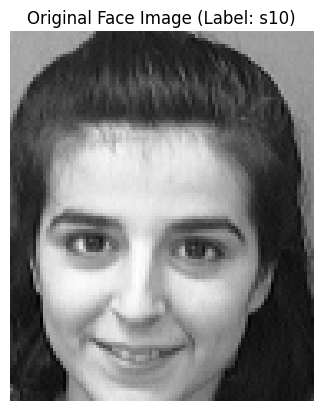

In [ ]:
#for example , image representation
import matplotlib.pyplot as plt

index = 11

original_image = X_train[index].reshape(112, 92)

plt.imshow(original_image, cmap='gray')
plt.title(f"Original Face Image (Label: {y_train[index]})")
plt.axis('off')
plt.show()


In [40]:
#cov matrix
cov_matrix = np.cov(X_train_std,rowvar=False)

eigval , eigvec = np.linalg.eigh(cov_matrix)

idx = eigval.argsort()[::-1]

In [41]:
eigval = eigval[idx]
eigvec = eigvec[:,idx]

k = 100
top_k_eigenvectors = eigvec[:, :k]
print(top_k_eigenvectors.shape)

(10304, 100)


In [ ]:
X_pca = np.dot(X_train_std, top_k_eigenvectors)
#360*10304 (10304,100)
X_reconstructed_std = np.dot(X_pca, top_k_eigenvectors.T)
X_reconstructed = scaler.inverse_transform(X_reconstructed_std)

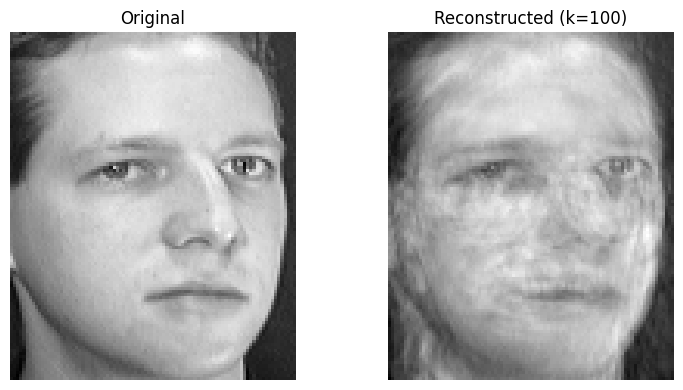

In [ ]:
index = 7
original_img = X_train[index].reshape(112, 92)
reconstructed_img = X_reconstructed[index].reshape(112, 92)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img, cmap='gray')
plt.title(f"Reconstructed (k={k})")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#Reconstruction Error
reconstruction_error = np.mean(np.square(X_train_std - X_reconstructed_std))
print("Reconstruction Error:", reconstruction_error)

Reconstruction Error: 0.1060008056744787


### **Eval_scratch()** is method to directly get the all reconstructed images set at different k values. Just have to give the index of the image.

In [37]:
def Eval_scratch(idx):
  k_val = [30,60,120,240,360]
  original_img2 = X_train[11].reshape(112, 92)
  plt.figure(figsize=(15, 8))
  plt.subplot(2, len(k_val)//2 + 1, 1)
  plt.imshow(original_img2, cmap='gray')
  plt.title("Original")
  plt.axis('off')
  for k in k_val:
    top_k_eigenvectors = eigvec[:, :k]
    X_pca = np.dot(X_train_std, top_k_eigenvectors)
    X_reconstructed_std = np.dot(X_pca, top_k_eigenvectors.T)
    X_reconstructed = scaler.inverse_transform(X_reconstructed_std)
    reconstruction_error = np.mean(np.square(X_train_std-X_reconstructed_std))

    print(f"For k = {k}, the reconstruction_error is:"+str(reconstruction_error))
    org_img = X_train[idx].reshape(112,92)
    recon_img = X_reconstructed[idx].reshape(112,92)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(recon_img,cmap='gray')
    plt.title(f"Reconstructed (k={k})")
    plt.axis('off')

For k = 30, the reconstruction_error is:0.2503000493345802
For k = 60, the reconstruction_error is:0.1621453756218123
For k = 120, the reconstruction_error is:0.08754456585423162
For k = 240, the reconstruction_error is:0.02479684430328341
For k = 360, the reconstruction_error is:3.5491736589461694e-29


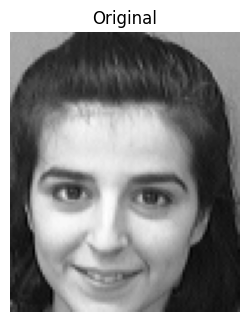

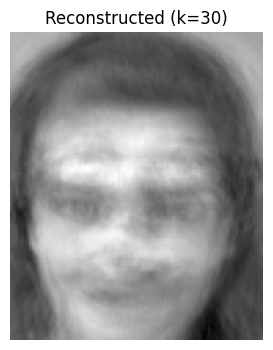

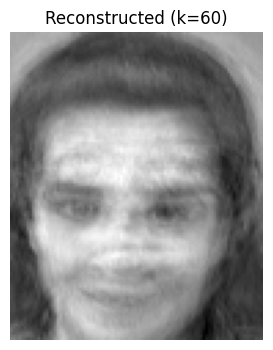

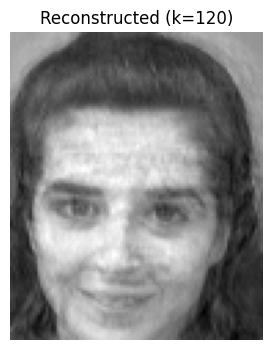

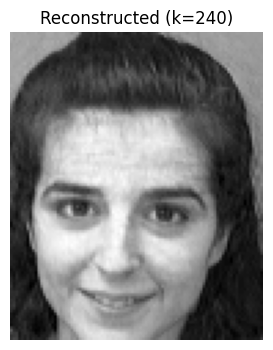

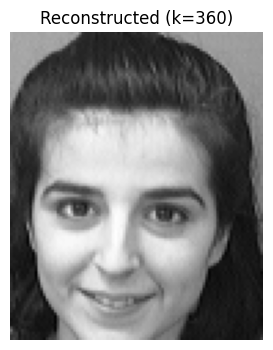

In [38]:
Eval_scratch(11)

# **3. Eigenfaces Visualization**

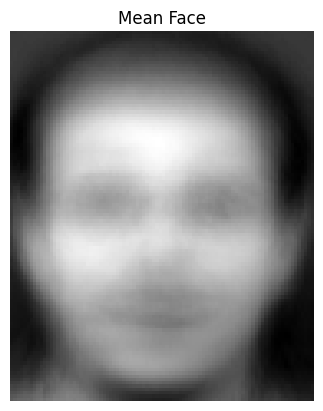

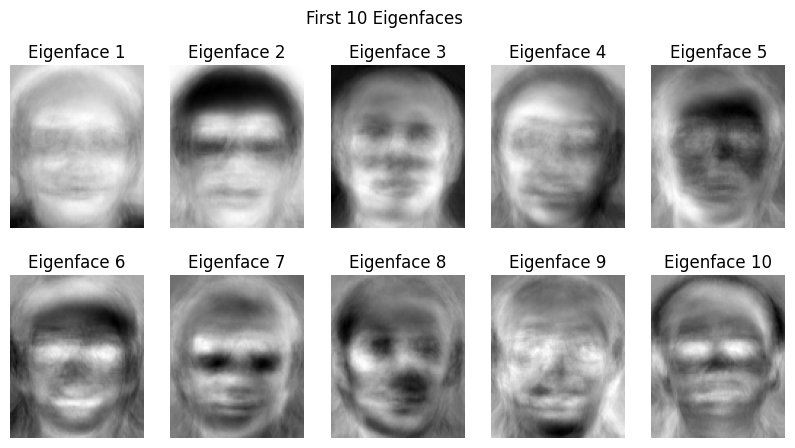

In [ ]:
# After computing PCA eigenvectors (eigvec) and mean_face
mean_face = np.mean(X_train, axis=0)

plt.imshow(mean_face.reshape(112, 92), cmap='gray')
plt.title("Mean Face")
plt.axis('off')
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigvec[:, i].reshape(112, 92), cmap='gray')
    ax.set_title(f"Eigenface {i+1}")
    ax.axis('off')
plt.suptitle("First 10 Eigenfaces")
plt.show()


# **4. Image Reconstruction**

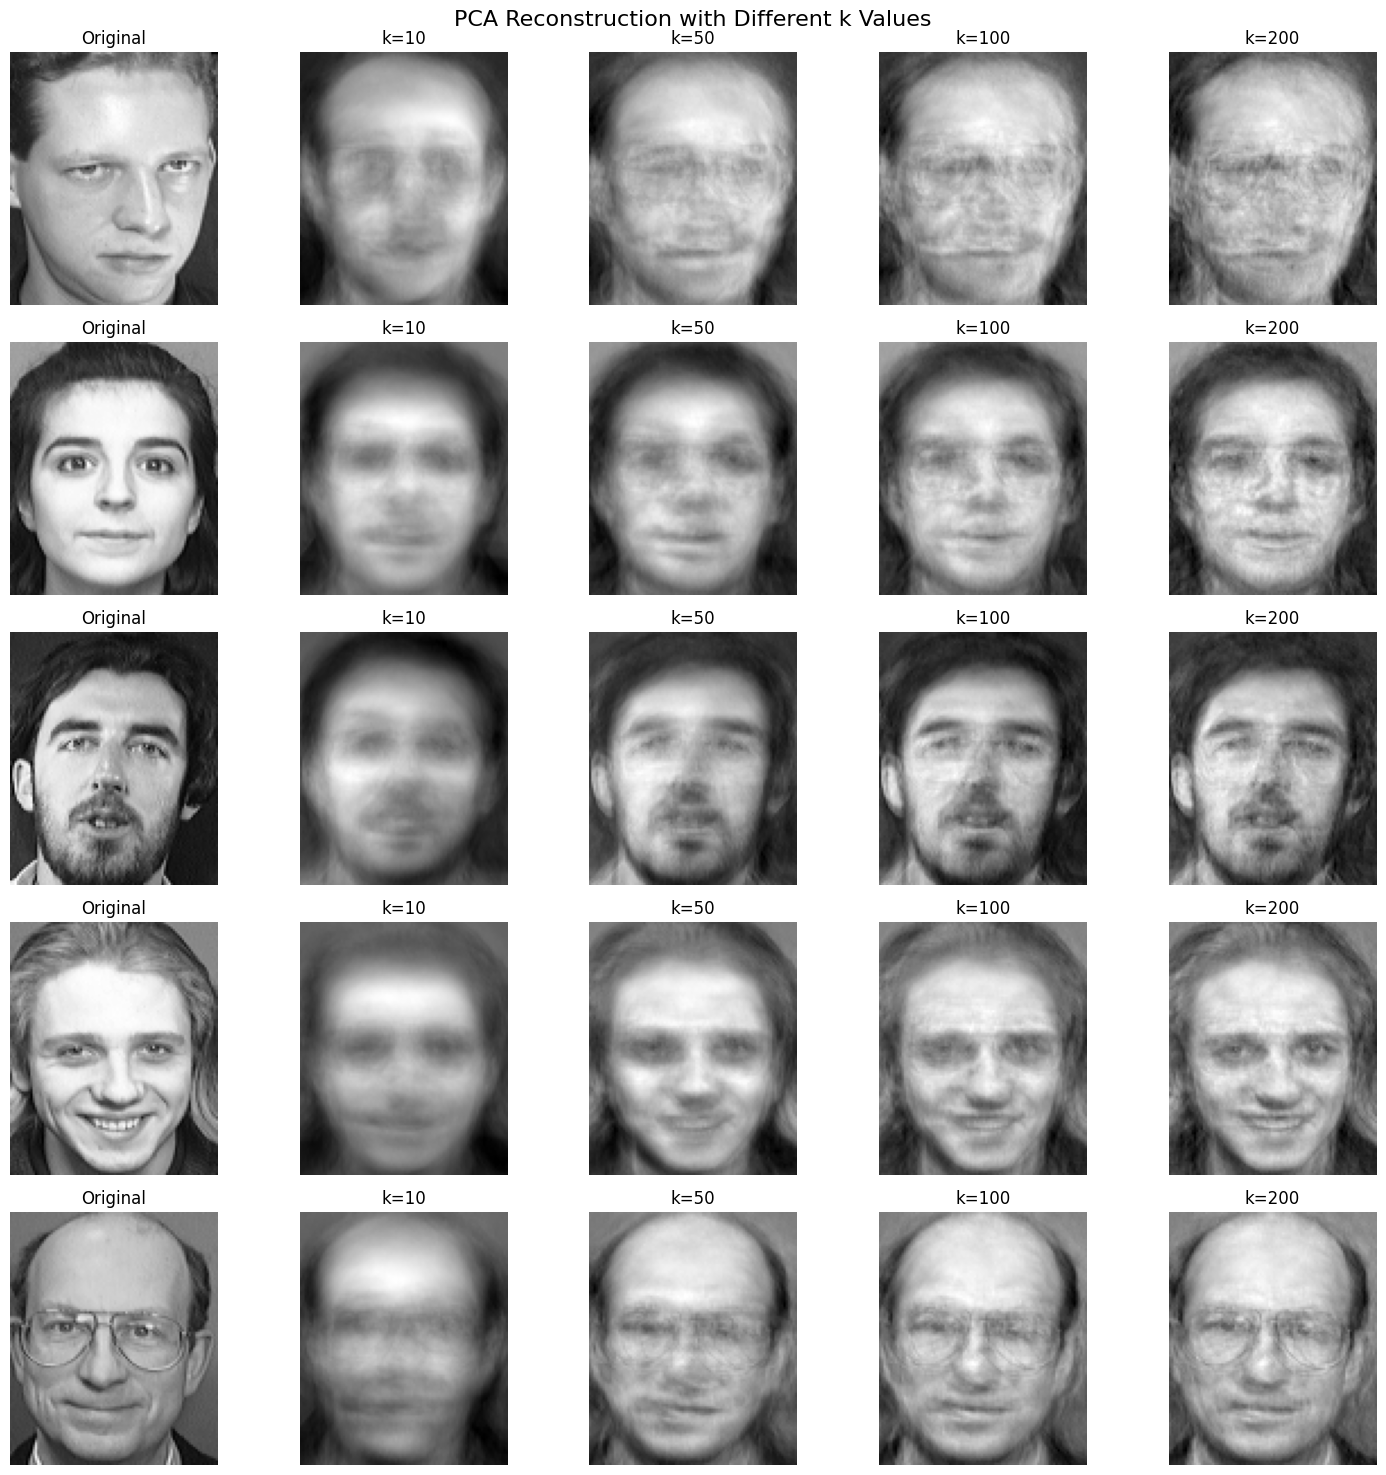

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def reconstruct_images(X_train, mean_face, eigvec, k_values, n_images=5):
    """
    Reconstruct first n_images from X_test using PCA with different k values.
    """
    # Step 1: Center the test data
    X_centered = X_test - mean_face

    # Step 2: Create subplot grid
    fig, axes = plt.subplots(n_images, len(k_values) + 1,
                             figsize=(3*(len(k_values)+1), 3*n_images))

    for i in range(n_images):
        # Step 3: Display original image
        axes[i, 0].imshow(X_test[i].reshape(112, 92), cmap='gray')
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        # Step 4: For each k, project and reconstruct
        for j, k in enumerate(k_values):
            Wk = eigvec[:, :k]  # First k eigenfaces
            projected = np.dot(X_centered[i], Wk)
            reconstructed = np.dot(projected, Wk.T) + mean_face

            axes[i, j+1].imshow(reconstructed.reshape(112, 92), cmap='gray')
            axes[i, j+1].set_title(f"k={k}")
            axes[i, j+1].axis('off')

    plt.suptitle("PCA Reconstruction with Different k Values", fontsize=16)
    plt.tight_layout()
    plt.show()

k_values = [10, 50, 100, 200]
reconstruct_images(X_train, mean_face, eigvec, k_values, n_images=5)


# **5. Face Recognition**

In [ ]:
def nearest_neighbor_classify(X_train_proj, y_train, X_test_proj):
    preds = []
    for test_vec in X_test_proj:
        distances = np.linalg.norm(X_train_proj - test_vec, axis=1)
        preds.append(y_train[np.argmin(distances)])
    return np.array(preds)

k_values = [10, 50, 100, 200]
accuracies = []

for k in k_values:
    top_k_eigvec = eigvec[:, :k]

    X_train_proj = np.dot(X_train_std, top_k_eigvec)
    X_test_proj = np.dot(X_test_std, top_k_eigvec)

    preds = nearest_neighbor_classify(X_train_proj, y_train, X_test_proj)
    acc = np.mean(preds == y_test) * 100
    accuracies.append(acc)
    print(f"k={k} → Accuracy: {acc:.2f}%")

k=10 → Accuracy: 95.00%
k=50 → Accuracy: 95.00%
k=100 → Accuracy: 95.00%
k=200 → Accuracy: 90.00%


# **6. Performance Analysis**

k = 10, Accuracy = 95.00%
k = 30, Accuracy = 95.00%
k = 60, Accuracy = 95.00%
k = 120, Accuracy = 92.50%
k = 150, Accuracy = 92.50%
k = 240, Accuracy = 90.00%


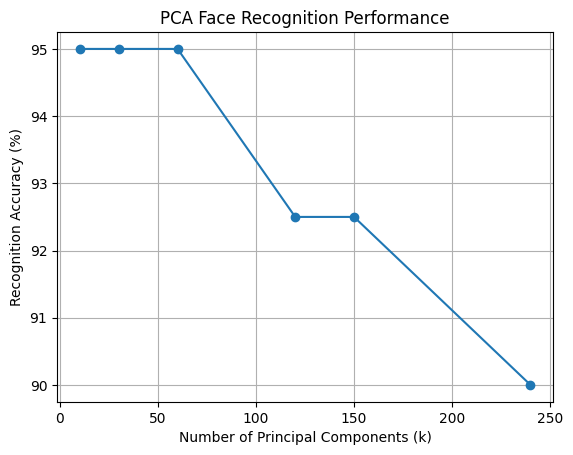

In [ ]:
k_values = [10, 30, 60, 120, 150, 240]
accuracies = []

for k in k_values:
    # Select top-k eigenvectors
    top_k_eigenvectors = eigvec[:, :k]

    # Project both training and test data
    X_train_pca = np.dot(X_train_std, top_k_eigenvectors)
    X_test_pca = np.dot(X_test_std, top_k_eigenvectors)

    # Train a classifier (example: k-NN)
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train_pca, y_train)

    # Evaluate
    accuracy = knn.score(X_test_pca, y_test) * 100
    accuracies.append(accuracy)
    print(f"k = {k}, Accuracy = {accuracy:.2f}%")

# Plot
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Recognition Accuracy (%)")
plt.title("PCA Face Recognition Performance")
plt.grid()
plt.show()


# **7. t-SNE Visualization (Bonus)**

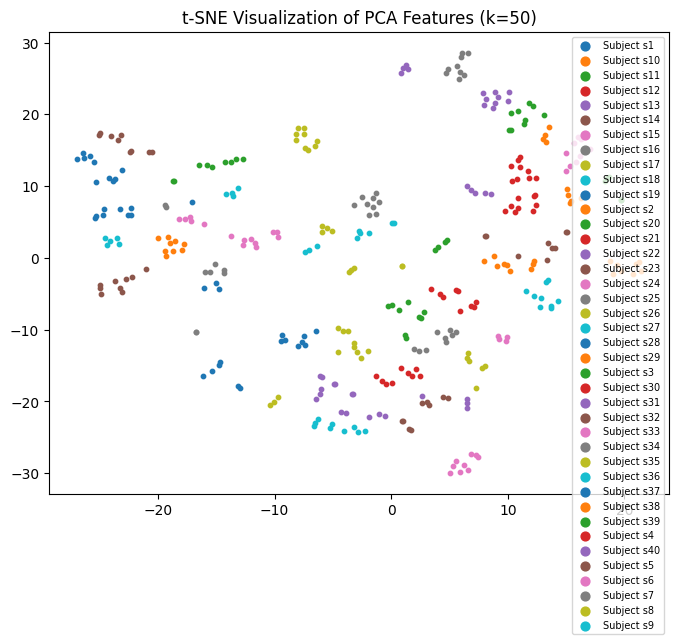

In [ ]:
from sklearn.manifold import TSNE

k_tsne = 50
top_k_eigvec = eigvec[:, :k_tsne]
X_train_proj = np.dot(X_train_std, top_k_eigvec)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_train_proj)

plt.figure(figsize=(8, 6))
for label in np.unique(y_train):
    idx = y_train == label
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=f"Subject {label}", s=10)
plt.legend(markerscale=2, fontsize=7)
plt.title("t-SNE Visualization of PCA Features (k=50)")
plt.show()


Yes , the subjects form distinct groups in low-dimensional space. all form clusters respective that they belong to same person (si)

#                                          **END**

# **Only For Understanding Purposes , and evaluating the scratch function with predefined func**

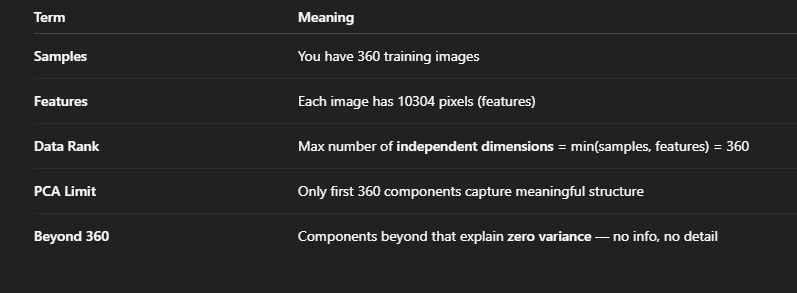

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 2: Apply PCA
n_components = 40  # you can change this based on how much variance you want to retain
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print("PCA-reduced training shape:", X_train_pca.shape)
print("PCA-reduced testing shape :", X_test_pca.shape)


PCA-reduced training shape: (360, 40)
PCA-reduced testing shape : (40, 40)


In [ ]:
def Eval(idx):
  k_val = [30,60,120,240,360]
  plt.figure(figsize=(15, 8))
  plt.subplot(2, len(k_val)//2 + 1, 1)
  plt.imshow(original_img, cmap='gray')
  plt.title("Original")
  plt.axis('off')
  for k in k_val:
    pca = PCA(k)
    X_train_pca = pca.fit_transform(X_train_std)
    X_test_pca = pca.transform(X_test_std)
    X_reconstruct = pca.inverse_transform(X_train_pca)
    X_reconstruct_std = scaler.inverse_transform(X_reconstruct)
    reconstruction_error = np.mean(np.square(X_train_std - X_reconstruct))
    print(f"For k = {k}, the reconstruction_error is:"+str(reconstruction_error))
    org_img = X_train[idx].reshape(112,92)
    recon_img = X_reconstruct_std[idx].reshape(112,92)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(recon_img,cmap='gray')
    plt.title(f"Reconstructed (k={k})")
    plt.axis('off')

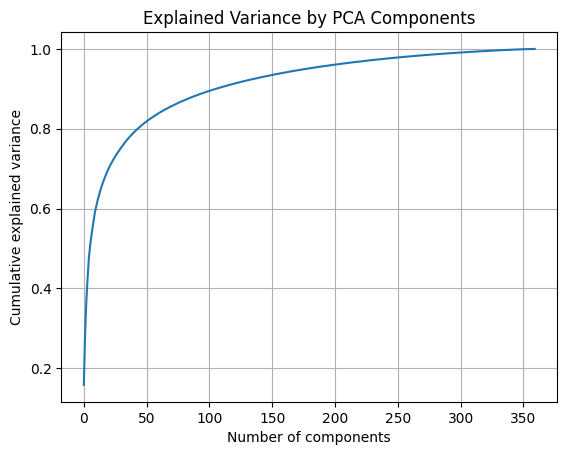

In [ ]:
pca_full = PCA().fit(X_train_std)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot cumulative explained variance
import matplotlib.pyplot as plt

plt.plot(cumulative_variance)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained Variance by PCA Components")
plt.grid()
plt.show()


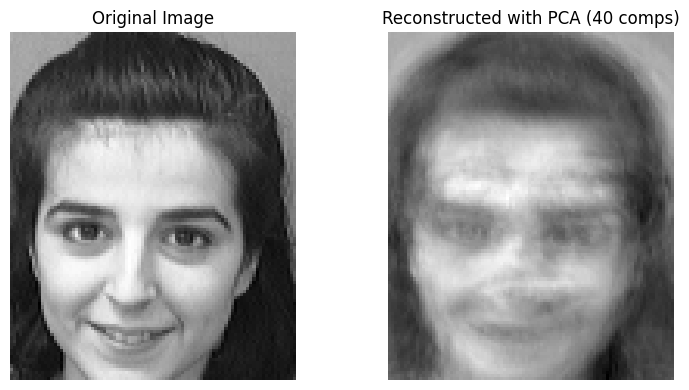

In [ ]:
import matplotlib.pyplot as plt

# Pick an image to reconstruct (e.g., first one)
index = 11

# Reconstruct from PCA (after inverse transform)
X_reconstructed = pca.inverse_transform(X_train_pca)

# Unstandardize the reconstructed image (reverse StandardScaler)
X_reconstructed_unscaled = scaler.inverse_transform(X_reconstructed)

# Get original and reconstructed image
original_img = X_train[index].reshape(112, 92)  # original image
reconstructed_img = X_reconstructed_unscaled[index].reshape(112, 92)

# Plot side by side
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img, cmap='gray')
plt.title(f"Reconstructed with PCA ({pca.n_components_} comps)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#Reconstruction Error
re = np.mean(np.square(X_train_std - pca.inverse_transform(X_train_pca)))
print(re)

0.21209657437018795


For k = 30, the reconstruction_error is:0.25031055378962225
For k = 60, the reconstruction_error is:0.16272048761998187
For k = 120, the reconstruction_error is:0.08843054394489923
For k = 240, the reconstruction_error is:0.025297705043518345
For k = 360, the reconstruction_error is:6.690313865827787e-30


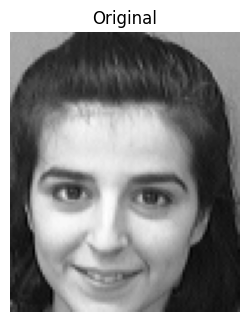

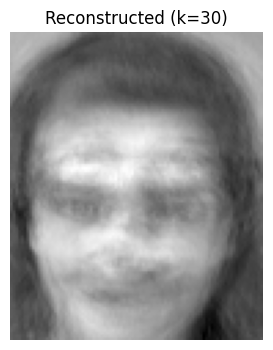

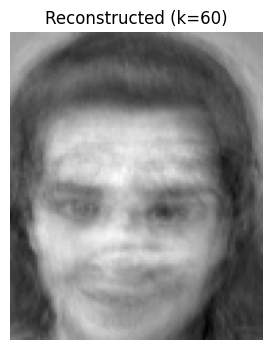

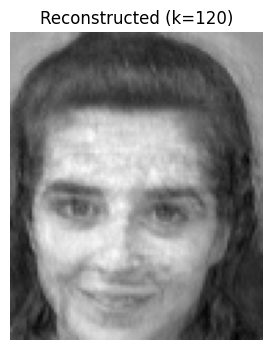

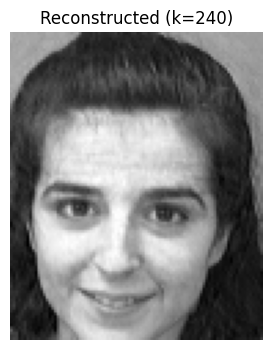

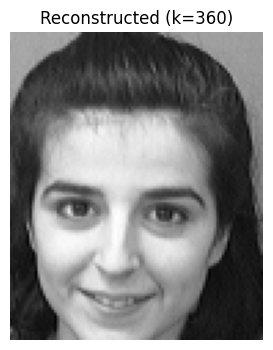

In [ ]:
Eval(11)